In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.ndimage import gaussian_filter
from importlib import reload
import datetime as dt
sys.path.append(r'D:\07. Software\jupyter')
# sys.path.append(r'D:\My Drive go.ugr.es\07. Software\jupyter')
from utils_gfat import lidar, plot, aeronet, lidarQA, ecmwf
from utils_gfat import lidar_elastic_retrieval
import lidar_processing.lidar_processing.helper_functions as helper_functions
import pdb

In [2]:
reload(lidar_elastic_retrieval)
reload(lidarQA)

<module 'utils_gfat.lidarQA' from 'D:\\07. Software\\jupyter\\utils_gfat\\lidarQA.py'>

In [3]:
day_=9
date_ini = dt.datetime.strptime('202107%02d' % day_,'%Y%m%d')
date_ = date_ini
year, month, day = date_.year, date_.month, date_.day
datestr = '%d%02d%02d' % (year, month, day)
print(datestr)
ini_date_str = '202107%02dT160000' % day_
end_date_str = '202107%02dT170000' % day_
ini_date = dt.datetime.strptime(ini_date_str,'%Y%m%dT%H%M%S')
end_date = dt.datetime.strptime(end_date_str,'%Y%m%dT%H%M%S')
rs_fl = os.path.join(r'Y:\datos\MULHACEN\1a\%d\%02d\%02d' % (year, month, day), 'mhc_1a_Prs_%s.nc' % datestr)  
dc_fl = os.path.join(r'Y:\datos\MULHACEN\1a\%d\%02d\%02d' % (year, month, day), 'mhc_1a_Pdc_%s_*.nc' % datestr)  
ecmwf_fl = os.path.join(r'Y:\datos\ECMWF\%s' % year, '%s_granada_ecmwf.nc' % datestr)
outputdir = r'C:\Users\Usuario\Downloads'
ecmwf_ds = xr.open_dataset(ecmwf_fl)
lr_aer = 50
ymin = 7000
ymax = 9000

#Lidar signal
iwds = lidar.preprocessing(rs_fl, dc_fl, channels=[0, 2, 4, 6], 
                          deadtime_flag=False, 
                          zerobin_flag=False,
#                           ini_date=ini_date_str, 
#                           end_date=end_date_str,
                          end_range=ymax)
height = iwds['range']


#Temperature and pressure
# date_ecmwf = ecmwf.nearest_datetime(ecmwf_ds['time'].values, pd.Timestamp(ini_date).to_datetime64())
# ecmwf_profile = ecmwf_ds.sel(time=slice(date_ecmwf,date_ecmwf)).mean('time').swap_dims({'level': 'height'})    
# pressure_prf = ecmwf_profile['pressure'].interp({'height': height}).interpolate_na(dim='range', method="linear", fill_value="extrapolate").values
# temperature_prf = ecmwf_profile['temperature'].interp({'height': height}).interpolate_na(dim='range', method="linear", fill_value="extrapolate").values
temperature_prf = np.ones(height.size)*np.nan
pressure_prf = np.ones(height.size)*np.nan
for i, _height in enumerate(height):
    sa = helper_functions.standard_atmosphere(_height)
    pressure_prf[i] = sa[0]
    temperature_prf[i] = sa[1]


20210709
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']


In [5]:
rcs_dict={355: 'corrected_rcs_04', 532: 'total_rcs532_an', 1064:'corrected_rcs_06'}
channel_dict={355: [4], 532: [0,2], 1064:[6]}

#Inversión KLETT para hallar la razón lidar
beta_part ={355: [], 532: [], 1064: []}
beta_total ={355: [], 532: [], 1064: []}
beta_mol ={355: [], 532: [], 1064: []}
alpha_mol ={355: [], 532: [], 1064: []}
od_total ={355: [], 532: [], 1064: []}
att_beta_total ={355: [], 532: [], 1064: []}
att_beta_total_rcs ={355: [], 532: [], 1064: []}
resolution = np.median(np.diff(height))
for wavelength in [355, 532, 1064]:
    wave_rcs_ = rcs_dict[wavelength]
    channels_ = channel_dict[wavelength]

    #Atmospheric conditions from 
    molecular_profiles = lidarQA.molecular_properties(wavelength, pressure_prf, temperature_prf, height, component='total')
    beta_mol[wavelength] = molecular_profiles['molecular_beta'].values    
    lr_mol = molecular_profiles['molecular_lidar_ratio'].values   
    alpha_mol[wavelength] = molecular_profiles['molecular_alpha'].values   
    abetamol = molecular_profiles['attenuated_molecular_beta']
        
    rcs = iwds[wave_rcs_].sel(time=slice(ini_date,end_date)).mean('time')
    beta_part[wavelength] = lidar_elastic_retrieval.klett(rcs.values, height.values, beta_mol[wavelength], lr_mol,
                                  lr_aer = 50, ymin = 7000, ymax = 8000)
    
    od_total[wavelength] = integrate.cumtrapz(alpha_mol[wavelength] + beta_part[wavelength]*lr_aer, dx=resolution, initial=0)
    beta_total[wavelength] = beta_part[wavelength]+beta_mol[wavelength]
    att_beta_total[wavelength] = beta_total[wavelength]*np.exp(-2*od_total[wavelength])

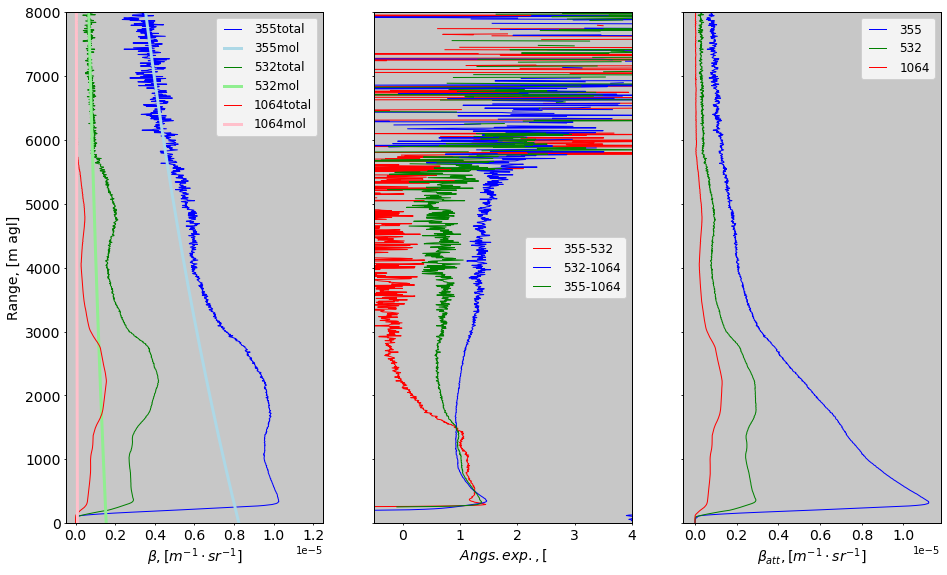

In [20]:
fig, ax = plt.subplots(figsize=[15,10])
ax1 = plt.subplot(1,3,1)
ax1.plot(beta_total[355], height, c='b', label='355total')
ax1.plot(beta_mol[355], height, c='lightblue', lw=3, label='355mol')
ax1.plot(beta_total[532], height, c='green', label='532total')
ax1.plot(beta_mol[532], height, c='lightgreen', lw=3, label='532mol')
ax1.plot(beta_total[1064], height, c='red', label='1064total')
ax1.plot(beta_mol[1064], height, c='pink', lw=3, label='1064mol')
ax1.set_xlabel('$\\beta, [m^{-1}\cdot sr^{-1}]$')
ax1.set_ylabel('Range, [m agl]')
ax1.set_xlim(-5e-7,1.25e-5)
ax1.set_ylim([0,8000])
ax1.legend(fontsize='large')
ae355_532 = -np.log(beta_part[532]/beta_part[355])/np.log(532/355)
ae532_1064 = -np.log(beta_part[1064]/beta_part[532])/np.log(1064/532)
ae355_1064 = -np.log(beta_part[1064]/beta_part[355])/np.log(1064/355)
ax2 = plt.subplot(1,3,2)
ax2.plot(ae355_532, height, c='r', label='355-532')
ax2.plot(ae532_1064, height, c='b', label='532-1064')
ax2.plot(ae355_1064, height, c='g', label='355-1064')
ax2.set_xlim(-0.5,4)
ax2.set_xlabel('$Angs. exp., [#]$')
ax2.legend(fontsize='large')
ax2.set_ylim([0,8000])
ax2.set_yticklabels([])
ax3 = plt.subplot(1,3,3)
ax3.plot(att_beta_total[355], height, c='b', label='355')
ax3.plot(att_beta_total[532], height, c='g', label='532')
ax3.plot(att_beta_total[1064], height, c='r', label='1064')
# ax3.set_xlim(-0.5,4)
ax3.legend(fontsize='large')
ax3.set_xlabel('$\\beta_{att}, [m^{-1}\cdot sr^{-1}]$')
ax3.set_ylim([0,8000])
ax3.set_yticklabels([])
for ax_ in [ax1, ax2, ax3]:
    plot.font_axes(ax_)